In [ ]:
w# Plant Disease Detection using CNN – Fully working in Google Colab
!pip install -q tensorflow tensorflow-datasets matplotlib seaborn scikit-learn

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))  # Should show your Colab GPU

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Try to load the official PlantVillage dataset (54,305 images, 38 classes)
try:
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )
    print("Real PlantVillage dataset loaded successfully!")
    NUM_CLASSES = ds_info.features['label'].num_classes
    class_names = ds_info.features['label'].names

except Exception as e:
    print("No internet or TFDS failed → creating dummy dataset")
    def create_dummy_data(num_classes=10, samples_per_class=800):
        X = np.random.randint(0, 256, (num_classes*samples_per_class, 224, 224, 3), dtype=np.uint8)
        y = np.repeat(np.arange(num_classes), samples_per_class)
        return X, y

    X, y = create_dummy_data()
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_val   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    ds_test  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    NUM_CLASSES = 10
    class_names = [f"Disease_{i}" for i in range(NUM_CLASSES)]

print(f"Number of classes: {NUM_CLASSES}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.75723L_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Real PlantVillage dataset loaded successfully!
Number of classes: 38


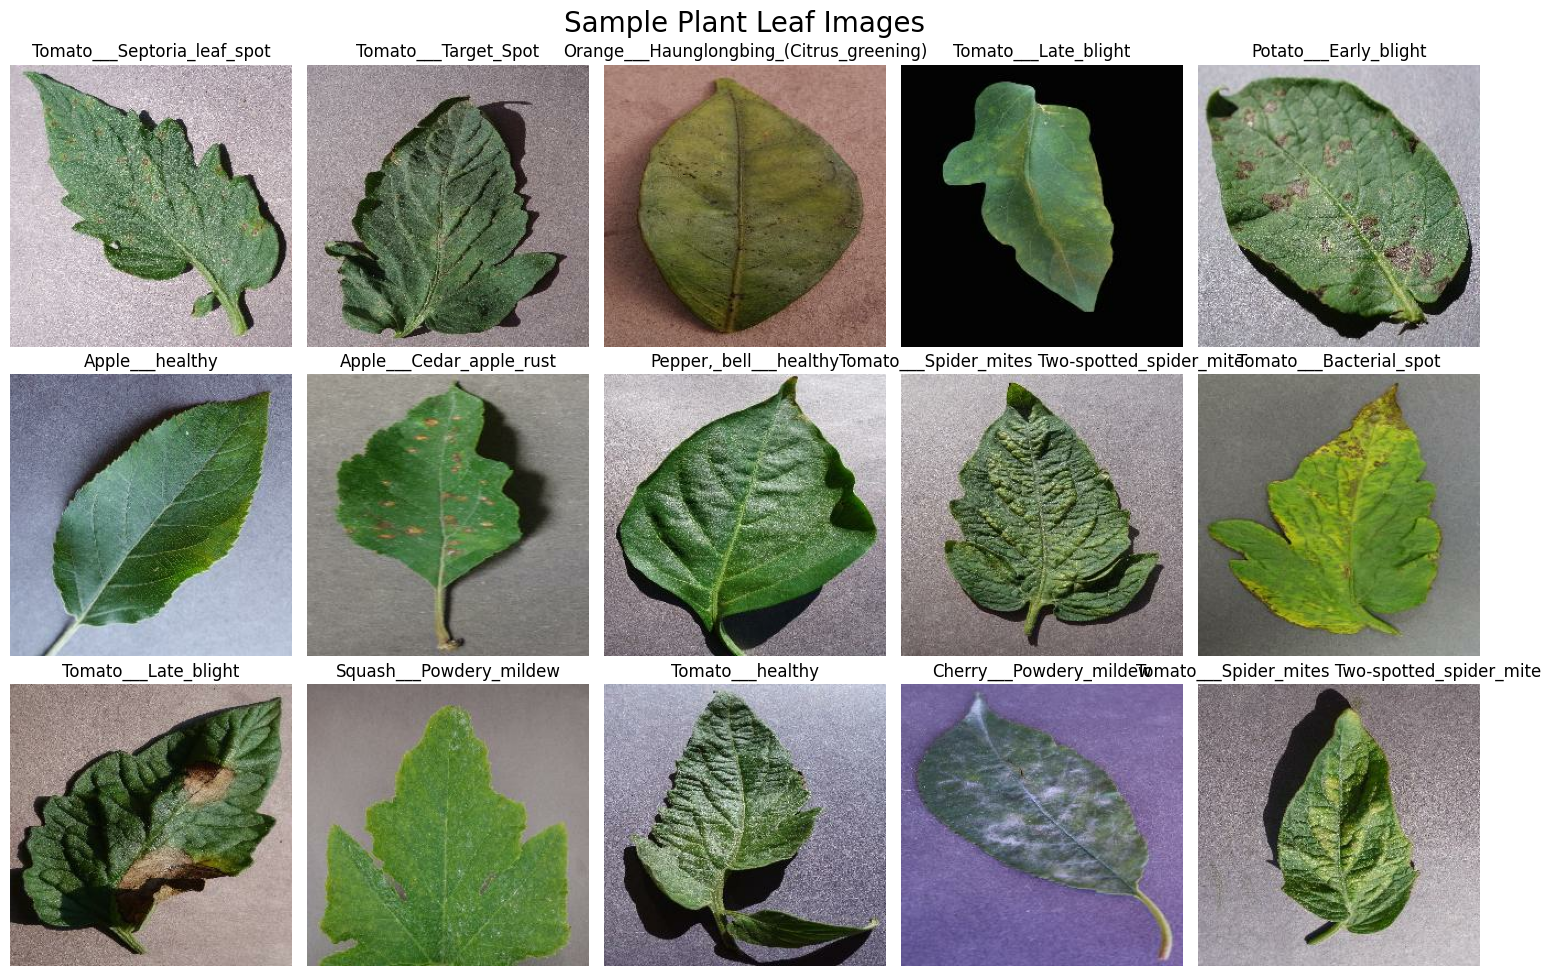

In [ ]:
plt.figure(figsize=(15, 10))
for i, (img, label) in enumerate(ds_train.take(15)):
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[label.numpy()] if hasattr(label, 'numpy') else class_names[label])
    plt.axis('off')
plt.suptitle("Sample Plant Leaf Images", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img, label

# Apply to pipelines
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val  = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),  # Better than Flatten for large inputs
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,414 (2.07 MB)

 Trainable params: 540,454 (2.06 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_plant_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)
]

In [ ]:
EPOCHS = 30

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4596 - loss: 1.9344
Epoch 1: val_accuracy improved from -inf to 0.74130, saving model to best_plant_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 134s 85ms/step - accuracy: 0.4597 - loss: 1.9340 - val_accuracy: 0.7413 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 2/30
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7694 - loss: 0.7239
Epoch 2: val_accuracy improved from 0.74130 to 0.89100, saving model to best_plant_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 108s 78ms/step - accuracy: 0.7694 - loss: 0.7238 - val_accuracy: 0.8910 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 3/30
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8633 - loss: 0.4338
Epoch 3: val_accuracy improved from 0.89100 to 0.89265, saving model to best_plant_model.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 106s 77ms/step - accuracy: 0.8633 - loss: 0.4338 - val_accuracy: 0.8927 - val_loss: 0.3193 - learning_rate: 0.0010
Epoch 4/30
13

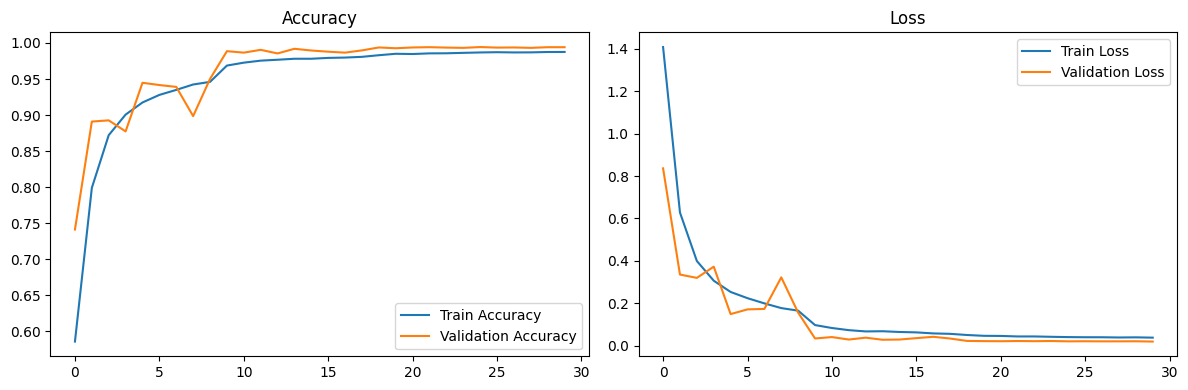

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Final Test Accuracy: 99.34%
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step

Classification Report
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00        58
                            Apple___Black_rot       1.00      1.00      1.00        65
                     Apple___Cedar_apple_rust       1.00      1.00      1.00        25
                              Apple___healthy       1.00      1.00      1.00       159
                          Blueberry___healthy       1.00      1.00      1.00       133
                             Cherry___healthy       1.00      0.99      0.99        90
                      Cherry___Powdery_mildew       1.00      1.00      1.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.84      0.90        56
                           Corn___Common_rust       0.99      1.00      1.00       127
                               Corn_

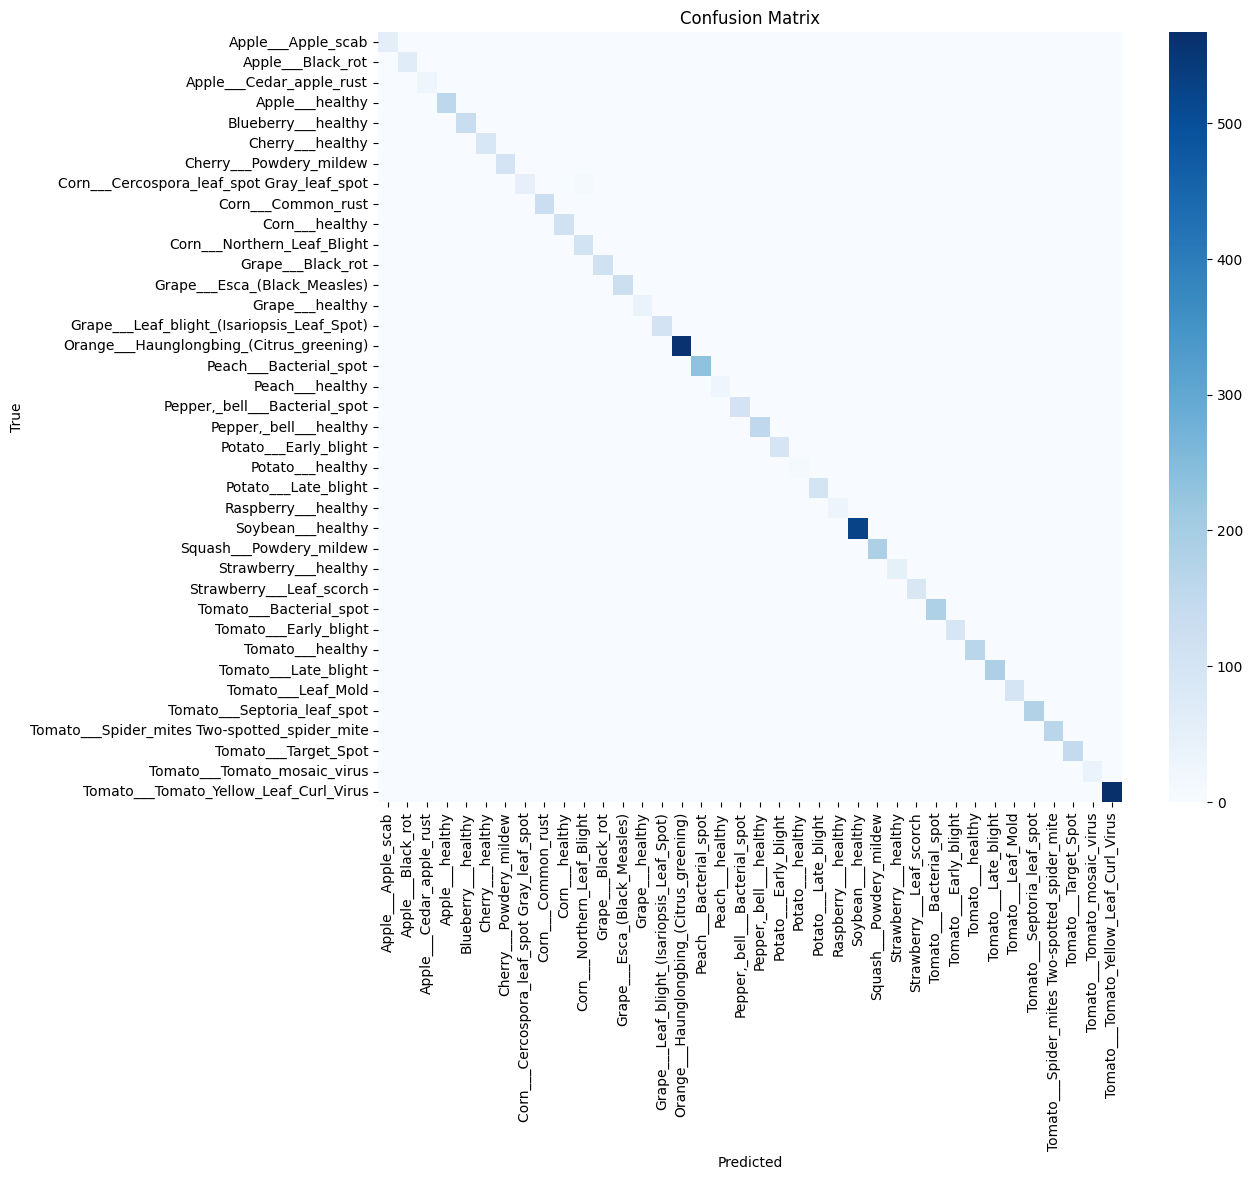

In [ ]:
# Load best model
model = tf.keras.models.load_model('best_plant_model.keras')

test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# Predictions for report
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = np.argmax(model.predict(ds_test), axis=1)

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix (only first 15 classes if too many)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


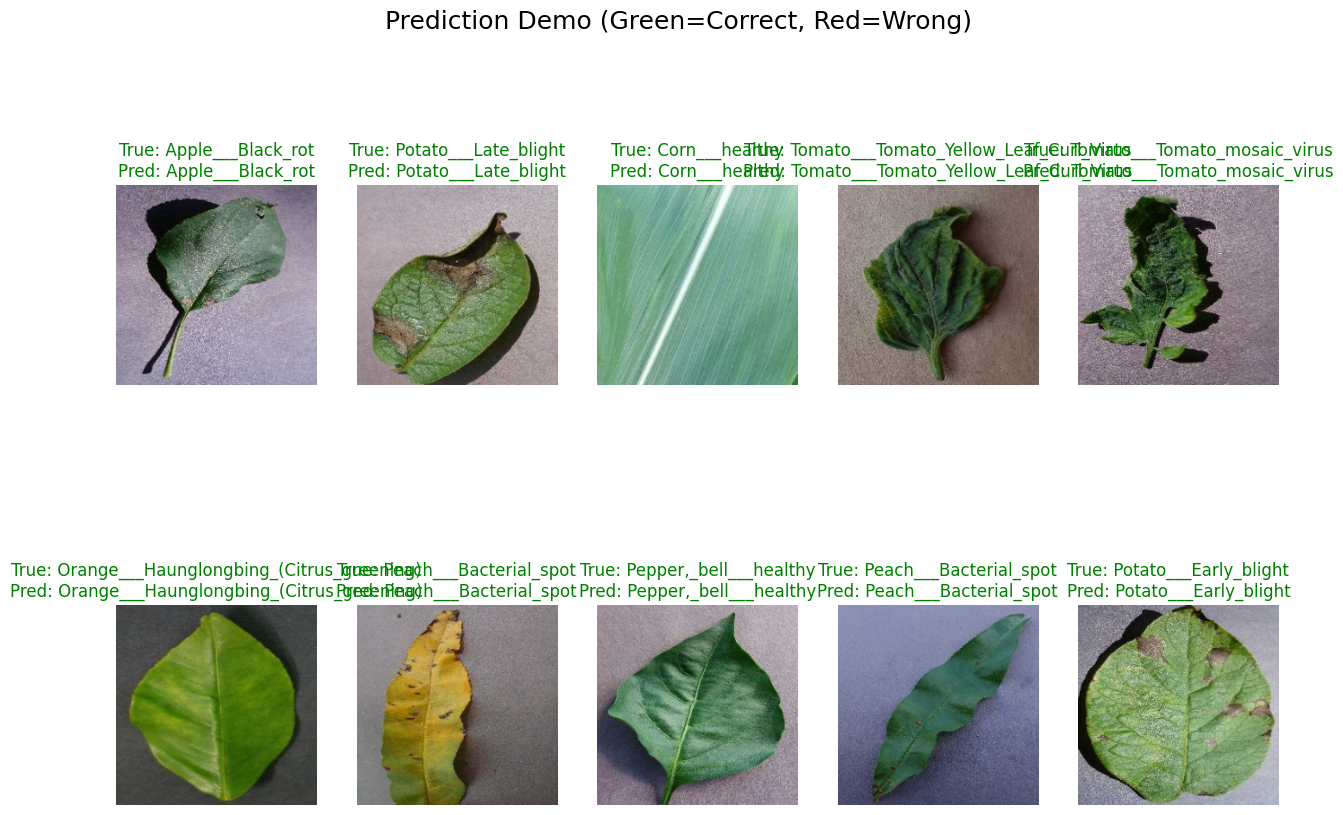

In [ ]:
def show_predictions(num=10):
    for batch in ds_test.take(1):
        images, labels = batch
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)

        plt.figure(figsize=(15,10))
        for i in range(num):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i])
            color = 'green' if pred_labels[i] == labels[i] else 'red'
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}", color=color)
            plt.axis('off')
        plt.suptitle("Prediction Demo (Green=Correct, Red=Wrong)", fontsize=18)
        plt.show()
        break

show_predictions()